In [27]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import yaml

import torch
import torchvision
from torch.utils.data import DataLoader

from utils_data import CelebFacesDataset, get_dataloader
from help_eval import evaluate, predict
from utils_train import train_model
from utils_random_seed import set_random_seeds
from ploting_temp import plot_

### yaml settings file.

In [2]:
with open('settings.yaml', 'r') as f:
    data = yaml.safe_load(f)

data

{'BATCH_SIZE': 1024,
 'NUM_EPOCHS': 50,
 'RANDOM_SEED': 42,
 'LEARNING_RATE': 0.05,
 'DROP_PROBA': 0.2,
 'THRESHOLD': 0.5,
 'IMAGE_SIZE': 128,
 'FAN_OUT1': 1024,
 'FAN_OUT2': 512}

### Setting a fixed seed.

In [3]:
set_random_seeds(data['RANDOM_SEED'])
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

## Reading `labels.csv`

In [4]:
labels = pd.read_csv('data/CF/labels.csv')
print(labels.shape)
labels.head()

(202599, 41)


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


###  Replace -1 with 0, and settings `image_id` as the dataframe index.

In [5]:
labels.set_index('image_id', inplace=True)
labels = labels.map(lambda x: 0 if x == -1 else 1)
print(labels.shape)
labels.head()

(202599, 40)


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


## Reading `eval_partition.csv`

In [6]:
eval_partition = pd.read_csv('data/CF/eval_partition.csv')
print(eval_partition.shape)
print(eval_partition['partition'].value_counts())
eval_partition.head()

(202599, 2)
partition
0    162770
2     19962
1     19867
Name: count, dtype: int64


,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


### Fetching images names

In [7]:
groups = eval_partition.groupby('partition')

train_images = groups.get_group(0)['image_id'].tolist()
val_images = groups.get_group(1)['image_id'].tolist()
test_images = groups.get_group(2)['image_id'].tolist()

# We will do the `train/val/test` split according to the recommended split ranges.

### Creating `train/val/test` folders.

In [8]:
if not os.path.exists('data/CF/train'):
    os.mkdir('data/CF/train')
if not os.path.exists('data/CF/val'):
    os.mkdir('data/CF/val')
if not os.path.exists('data/CF/test'):
    os.mkdir('data/CF/test')

### inserting training images into train folder.

In [9]:
for image_name in tqdm(train_images):
    source = os.path.join('data/CF/img_align_celeba', image_name)
    destination = os.path.join('data/CF/train', image_name)
    os.rename(source, destination)

  0%|          | 0/162770 [00:00<?, ?it/s]

### inserting validation images into val folder.

In [10]:
for image_name in tqdm(val_images):
    source = os.path.join('data/CF/img_align_celeba', image_name)
    destination = os.path.join('data/CF/val', image_name)
    os.rename(source, destination)

  0%|          | 0/19867 [00:00<?, ?it/s]

### inserting testing images into test folder.

In [11]:
for image_name in tqdm(test_images):
    source = os.path.join('data/CF/img_align_celeba', image_name)
    destination = os.path.join('data/CF/test', image_name)
    os.rename(source, destination)

  0%|          | 0/19962 [00:00<?, ?it/s]

### Create three csv files, each carrying the attributes of `train/val/test` images.

In [12]:
train_attr = labels.loc[train_images]
val_attr = labels.loc[val_images]
test_attr = labels.loc[test_images]

### Now we check the imbalance of the training data using a bar plot.

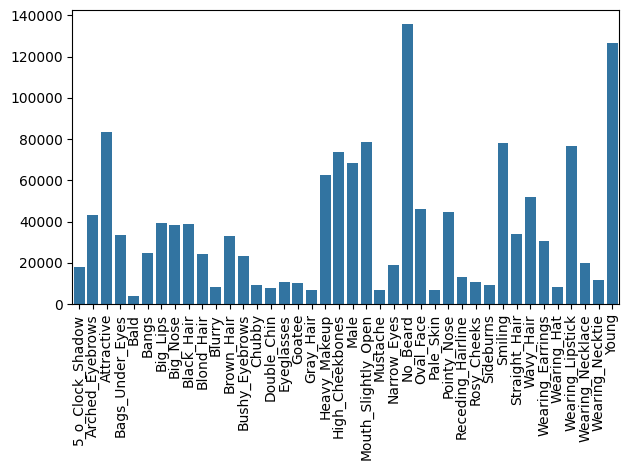

In [13]:
train_attr_counts = train_attr.sum(axis=0)
sns.barplot(train_attr_counts)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Since there is imbalance in the data as expected. We calculate the percentage of presence for each class and use as class weights in the loss function.

In [14]:
n_samples = train_attr.shape[0]
n_classes = train_attr.shape[1]

weights = torch.tensor([n_samples / (n_classes * count) for count in train_attr_counts], device=device)

### Calculate the mean ans standard deviation for the training data.

In [15]:
temp_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize([data['IMAGE_SIZE'], data['IMAGE_SIZE']])
])

train_dataset = CelebFacesDataset(images_dir='data/CF/train',
                                  images_names=train_images,
                                  labels=train_attr,
                                  transforms=temp_transforms)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=9000)

training_mean, training_std = [], []
for images, _ in tqdm(train_loader):
    images = images.numpy()
    batch_mean = np.mean(images, axis=(0, 2, 3))
    batch_std = np.std(images, axis=(0, 2, 3))
    training_mean.append(batch_mean)
    training_std.append(batch_std)

training_mean = torch.tensor(np.mean(training_mean, axis=0))
training_std = torch.tensor(np.mean(training_std, axis=0))

print('Mean:', training_mean)
print('Std Dev:', training_std)

# tensor([0.5065, 0.4260, 0.3833])
# tensor([0.3078, 0.2876, 0.2871])

  0%|          | 0/19 [00:00<?, ?it/s]

Mean: tensor([0.5065, 0.4260, 0.3833])
Std Dev: tensor([0.3078, 0.2876, 0.2871])


### We will use resnet50 from torchvision pretrained models.

In [16]:
model = torchvision.models.resnet101(weights=torchvision.models.ResNet101_Weights.DEFAULT)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Freeze the model's feature extraction part and do some modifications to the `fc` linear layer.

In [17]:
for p in model.parameters():
    p.requires_grad = False

model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, data['FAN_OUT1'], bias=False),
    torch.nn.ELU(inplace=True),
    torch.nn.BatchNorm1d(data['FAN_OUT1']),
    torch.nn.Dropout(data['DROP_PROBA']),
    
    torch.nn.Linear(data['FAN_OUT1'], data['FAN_OUT2'], bias=False),
    torch.nn.ELU(inplace=True),
    torch.nn.BatchNorm1d(data['FAN_OUT2']),
    torch.nn.Dropout(data['DROP_PROBA']),

    torch.nn.Linear(data['FAN_OUT2'], 40)
)

In [18]:
num_parameters = 0
for param in model.parameters():
    if param.requires_grad:
        num_parameters += param.numel()

print(f'Number of differentiable parameters: {num_parameters:_}')

Number of differentiable parameters: 2_645_032


### Setting up training and testing transforms.

In [19]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize([data['IMAGE_SIZE'], data['IMAGE_SIZE']]),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomRotation(45),
    torchvision.transforms.Normalize(training_mean, training_std)
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize([data['IMAGE_SIZE'], data['IMAGE_SIZE']]),
    torchvision.transforms.Normalize(training_mean, training_std)
])

In [20]:
train_loader = get_dataloader(batch_size=data['BATCH_SIZE'],
                              images_dir='data/CF/train',
                              images_names=train_images,
                              labels=train_attr,
                              transforms=train_transforms,
                              num_workers=5,
                              train_mode=True)

for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    print(type(images))
    print(type(labels))
    print(labels[0])
    break

torch.Size([1024, 3, 128, 128])
torch.Size([1024, 40])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [21]:
val_loader = get_dataloader(batch_size=data['BATCH_SIZE'],
                              images_dir='data/CF/val',
                              images_names=val_images,
                              labels=val_attr,
                              transforms=test_transforms,
                              num_workers=5,
                              train_mode=False)

for images, labels in val_loader:
    print(images.shape)
    print(labels.shape)
    print(type(images))
    print(type(labels))
    print(labels[0])
    break

torch.Size([1024, 3, 128, 128])
torch.Size([1024, 40])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1])


In [22]:
test_loader = get_dataloader(batch_size=data['BATCH_SIZE'],
                              images_dir='data/CF/test',
                              images_names=test_images,
                              labels=test_attr,
                              transforms=test_transforms,
                              num_workers=5,
                              train_mode=False)

for images, labels in val_loader:
    print(images.shape)
    print(labels.shape)
    print(type(images))
    print(type(labels))
    print(labels[0])
    break

torch.Size([1024, 3, 128, 128])
torch.Size([1024, 40])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1])


In [23]:
loss_fn = torch.nn.BCEWithLogitsLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=data['LEARNING_RATE'])
model = model.to(device)

In [24]:
logging_dict = train_model(model=model,
                           num_epochs=data['NUM_EPOCHS'],
                           optimizer=optimizer,
                           train_loader=train_loader,
                           val_loader=val_loader,
                           device=device,
                           loss_fn=loss_fn,
                           threshold=data['THRESHOLD'])

EPOCH: 001/050 | Batch: 000/158 | Loss: 0.1840
total_train_acc: 82.7727 | total_train_loss: 0.0703
total_val_acc: 86.1191 | total_val_loss: 0.0486
Elapsed Time: 3.5836881120999653 min
EPOCH: 002/050 | Batch: 000/158 | Loss: 0.0533
total_train_acc: 84.2946 | total_train_loss: 0.0598
total_val_acc: 86.5624 | total_val_loss: 0.0468
Elapsed Time: 7.5534844954808555 min
EPOCH: 003/050 | Batch: 000/158 | Loss: 0.0483
total_train_acc: 84.9406 | total_train_loss: 0.0558
total_val_acc: 86.8028 | total_val_loss: 0.0457
Elapsed Time: 11.32082009712855 min
EPOCH: 004/050 | Batch: 000/158 | Loss: 0.0490
total_train_acc: 85.3051 | total_train_loss: 0.0536
total_val_acc: 86.9916 | total_val_loss: 0.0448
Elapsed Time: 15.015356012185414 min
EPOCH: 005/050 | Batch: 000/158 | Loss: 0.0488
total_train_acc: 85.5469 | total_train_loss: 0.0522
total_val_acc: 87.1512 | total_val_loss: 0.0440
Elapsed Time: 18.722543362776438 min
EPOCH: 006/050 | Batch: 000/158 | Loss: 0.0491
total_train_acc: 85.7142 | total_t

### Saving the model

In [25]:
# Saving the model
torch.save(model.state_dict(), 'data/saved_model_ml_cls_final/model.pt')
torch.save(optimizer.state_dict(), 'data/saved_model_ml_cls_final/optimizer.pt')

# # Loading the model
# model.load_state_dict(torch.load('data/saved_model_ml_cls_final/model.pt'))
# optimizer.load_state_dict(torch.load('data/saved_model_ml_cls_final/optimizer.pt'))

### Plot train-vs-val accuracy.

In [28]:
total_train_acc = logging_dict[0]
total_train_loss = logging_dict[1]
total_val_acc = logging_dict[2]
total_val_loss = logging_dict[3]

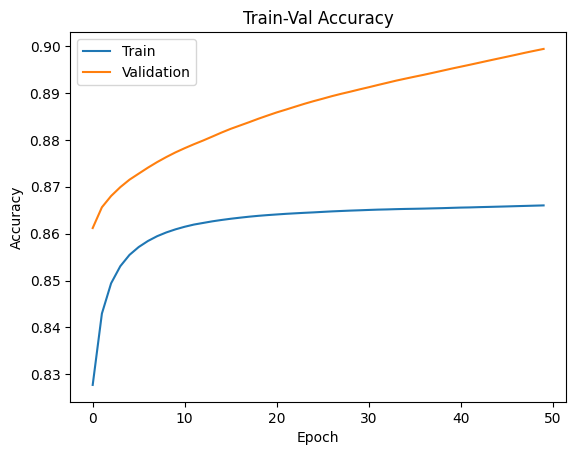

In [29]:
plot_(total_train_acc, total_val_acc, mode='accuracy')

### Plot train-vs-val loss.

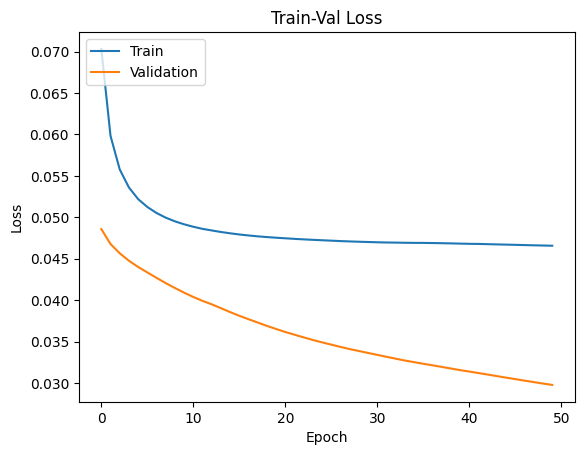

In [30]:
plot_(total_train_loss, total_val_loss, mode='loss')

# Note: the reason why there is a gap between training/validation accuracy and loss is due to the use of drop out. i.e., in during training not all the neurons where activated while in validation all the neurons are activated which leads to more robust performance.

### Evaluate the model performance on the test dataset.

In [31]:
evaluate(model, test_loader, device)

  0%|          | 0/20 [00:13<?, ?it/s]

85.3000657153224

### Now let's do predictions on some random images from `test dataset`.

Predicted Labels:
-------------

Arched_Eyebrows
Attractive
Brown_Hair
Heavy_Makeup
High_Cheekbones
Mouth_Slightly_Open
No_Beard
Oval_Face
Pointy_Nose
Smiling
Wavy_Hair
Wearing_Earrings
Wearing_Lipstick
Young


True Labels:
-------------

Arched_Eyebrows
Attractive
Big_Lips
Brown_Hair
Bushy_Eyebrows
Heavy_Makeup
High_Cheekbones
Mouth_Slightly_Open
No_Beard
Oval_Face
Pointy_Nose
Smiling
Wavy_Hair
Wearing_Lipstick
Young


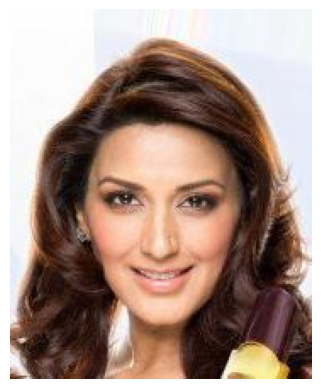

In [33]:
predict(model,
        image_path='data/CF/test/183558.jpg',
        threshold=0.5,
        transforms=test_transforms,
        labels=test_attr,
        device=device)

Predicted Labels:
-------------

Attractive
Bangs
Heavy_Makeup
High_Cheekbones
Mouth_Slightly_Open
No_Beard
Smiling
Wearing_Earrings
Wearing_Lipstick
Wearing_Necklace
Young


True Labels:
-------------

Arched_Eyebrows
Attractive
Bangs
Big_Lips
Heavy_Makeup
High_Cheekbones
Mouth_Slightly_Open
No_Beard
Smiling
Wearing_Earrings
Wearing_Lipstick
Wearing_Necklace


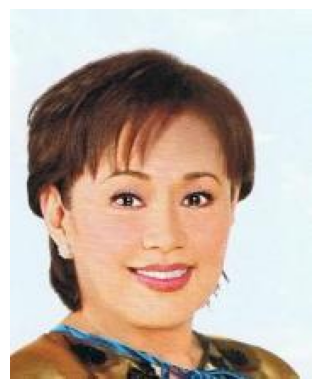

In [34]:
predict(model,
        image_path='data/CF/test/201400.jpg',
        threshold=0.5,
        transforms=test_transforms,
        labels=test_attr,
        device=device)